## G&F (2014) Redo
#### Basic regressions on old source data for Cl/OH partitioning in amphibole

This notebook replicates and potentially extends and improves upon the analysis on chlorine partitioning in igneous amphiboles from Giesting & Filiberto (2014) in American Mineralogist. That work was done with Excel and one of the main reasons I took a data science bootcamp was to learn how to do this sort of thing with better tools. So let me get back into it by doing the *identical* thing with better tools.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes
import seaborn as sns
%matplotlib inline
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score

/home/paulus/miniconda3/envs/amphibole/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [16]:
from itertools import combinations

In [32]:
import pickle

In [2]:
np.set_printoptions(precision=2,suppress=True)

The data in this file is the collection of features prepared from the amphibole compositions. The target ln K(Cl) was calculated using the Lesne et al. (2011) model for water speciation in melt (this is needed to determine how much OH- was in the melt competing for spots in the amphibole with Cl-). The alternative was the Dixon et al. (1995) model. The other models in the toolchain to calculate the various features were constant from scenario to scenario.

In [3]:
filename = "./AmphiboleProcessedRegressionData.csv"
amph_chem = pd.read_csv(filename)
amph_chem.columns

Index(['Mg', 'FeM', 'K/Vac+Na', 'Di/Hi M', 'Fe2+', 'Fe3+', 'Mg# F'ous',
       'ln(fH2O)', 'Si', 'Ti', 'AlM', 'Mn', 'Ca', 'Na', 'Avac', 'K', 'T',
       'lnP', 'AlT/Si', 'Mg#M', 'Mg#', 'Ca/FeB', 'K+Vac/Na', 'ln K(Cl)'],
      dtype='object')

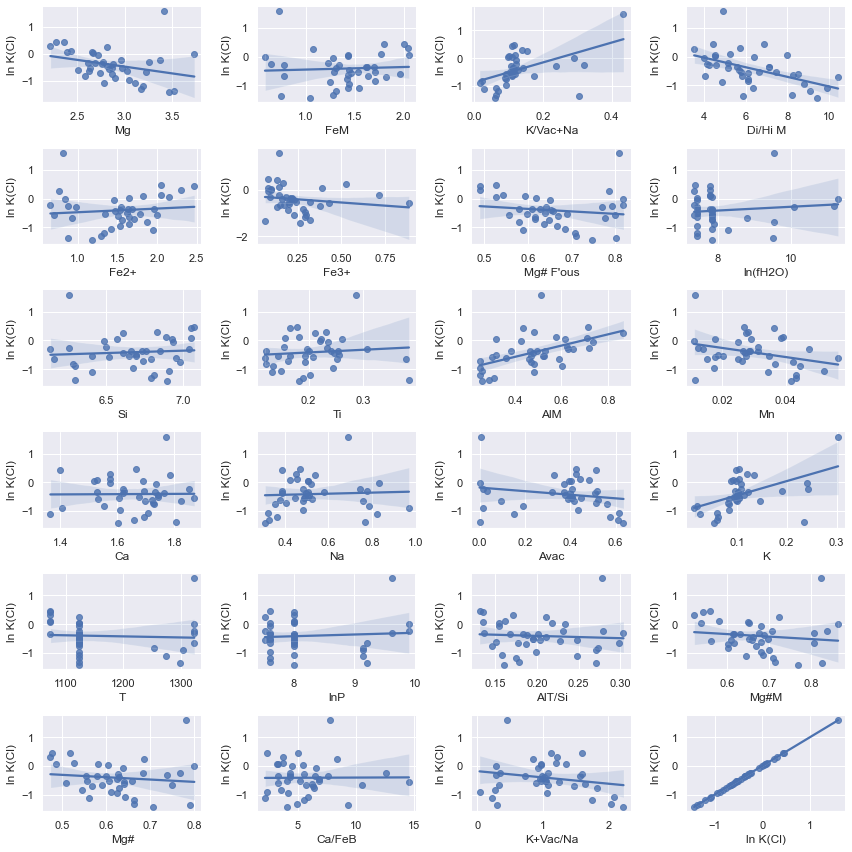

In [4]:
f,axes = plt.subplots(6, 4, figsize=(12,12))
sns.despine(left=True)
for i, col in enumerate(amph_chem.columns):
    sns.regplot(x=amph_chem[col],y=amph_chem['ln K(Cl)'],ax=axes[i//4,i%4])
plt.tight_layout()

In [5]:
XLesne3 = amph_chem[['K/Vac+Na','Mg','FeM']]
XLesne3.head()

,K/Vac+Na,Mg,FeM
0,0.434545,3.421042,0.733372
1,0.305333,3.526782,0.747619
2,0.289957,3.737951,0.586423
3,0.318876,3.379470,0.648122
4,0.236740,3.260124,0.781527


In [6]:
y = amph_chem['ln K(Cl)']
type(y)

pandas.core.series.Series

In [7]:
X1 = sm.add_constant(XLesne3)
Lesne3_model = sm.OLS(y,X1)
Lesne3_results = Lesne3_model.fit()

In [8]:
Lesne3_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln K(Cl)   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     27.41
Date:                Thu, 07 Apr 2022   Prob (F-statistic):           2.65e-09
Time:                        22:04:02   Log-Likelihood:                -10.638
No. Observations:                  39   AIC:                             29.28
Df Residuals:                      35   BIC:                             35.93
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6625      1.507      3.094      0.004       1.604       7.721
K/Vac+Na       5.6946      0.855      6.661      0.000       3.959       7.430
Mg            -1.7452      0.354     -4.935      0.000      -2.463      -1.027
FeM           -0.5681      0.359     -1.581      0.123      -1.298       0.161
==============================================================================
Omnibus:                       15.172   Durbin-Watson:                   2.535
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               29.936
Skew:                          -0.860   Prob(JB):                     3.16e-07
Kurtosis:                       6.933   Cond. No.                         101.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
Lesne3_model_noc = sm.OLS(y,XLesne3)
Lesne3_results_noc = Lesne3_model_noc.fit()
Lesne3_results_noc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               ln K(Cl)   R-squared (uncentered):                   0.746
Model:                            OLS   Adj. R-squared (uncentered):              0.725
Method:                 Least Squares   F-statistic:                              35.31
Date:                Thu, 07 Apr 2022   Prob (F-statistic):                    8.04e-11
Time:                        22:04:02   Log-Likelihood:                         -15.354
No. Observations:                  39   AIC:                                      36.71
Df Residuals:                      36   BIC:                                      41.70
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
K/Vac+Na       6.5881      0.895      7.358      0.000       4.772       8.404
Mg            -0.6788      0.088     -7.674      0.000      -0.858      -0.499
FeM            0.4874      0.126      3.876      0.000       0.232       0.742
==============================================================================
Omnibus:                       15.461   Durbin-Watson:                   2.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.711
Skew:                          -1.014   Prob(JB):                     4.31e-06
Kurtosis:                       6.330   Cond. No.                         48.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model has identical parameters to the model in the abstract of Giesting & Filiberto (2014). Thank God, that was easy.

### Automated feature reduction

Next step: Use automated feature selection to revisit this first regression. Let's try Lasso since it will actually kill features.

In [10]:
X = amph_chem.drop('ln K(Cl)',axis=1,inplace=False)
X.columns

Index(['Mg', 'FeM', 'K/Vac+Na', 'Di/Hi M', 'Fe2+', 'Fe3+', 'Mg# F'ous',
       'ln(fH2O)', 'Si', 'Ti', 'AlM', 'Mn', 'Ca', 'Na', 'Avac', 'K', 'T',
       'lnP', 'AlT/Si', 'Mg#M', 'Mg#', 'Ca/FeB', 'K+Vac/Na'],
      dtype='object')

In [11]:
lasso_model = Lasso(alpha = 0.007) # 1.0 is scikit-learn default
lasso_model.fit(X,y)

Lasso(alpha=0.007)

In [12]:
lasso_model.score(X,y)

0.6788836350143835

In [13]:
lasso_model.coef_

array([-0.51,  0.  ,  3.65, -0.12, -0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
       -0.  ,  0.  , -0.  , -0.  , -0.  , -0.  ,  0.  , -0.  ,  0.21,
       -0.  , -0.  , -0.  , -0.02, -0.  ])

In [14]:
lasso_noc = Lasso(alpha = 0.007,fit_intercept=False)
lasso_noc.fit(X,y)
print(lasso_noc.score(X,y))
lasso_noc.coef_

0.6883144754267808


/home/paulus/miniconda3/envs/amphibole/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.385e+00, tolerance: 1.978e-03
  model = cd_fast.enet_coordinate_descent(


array([-0.12,  0.47,  3.84, -0.13,  0.  ,  0.  ,  0.  ,  0.  ,  0.12,
       -0.  ,  0.31, -0.  , -0.  , -0.  , -0.  ,  0.  , -0.  ,  0.1 ,
       -0.  , -0.  , -0.  , -0.02,  0.  ])

Actually, Lasso is doing a terrible job of trying to get to the result I did using human intuition, including crystal chemistry. I suppose I can be happy about that in a sense.

In [15]:
lasso_pag = Lasso(alpha = 0.0,fit_intercept=False)
lasso_pag.fit(XLesne3,y)
print(r2_score(lasso_pag.predict(XLesne3),y))
lasso_pag.coef_

0.37180091580463004


/tmp/ipykernel_26032/4215977416.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_pag.fit(XLesne3,y)
/home/paulus/miniconda3/envs/amphibole/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/paulus/miniconda3/envs/amphibole/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.509e+00, tolerance: 1.978e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinat

array([ 6.59, -0.68,  0.49])

I seem to see a lack of agreement on the score between Excel in 2013/2014 when I wrote the paper, statsmodels, the native "score" function of the Lasso regressor, and the r2_score in scikit-learn, but I haven't chased that down.

The Lasso routine also hacks the score severely if I set alpha to a finite value.

However, it is most important that the Lasso regressor replicates the feature coefficients that statsmodels and Excel produce, and they do all agree.

### Semi-automated feature reduction
Now I will do what I tried to do manually in Excel over some absurdly long period of time. Instead of fretting about which pathway of variables to delete from 19 to 16 to 8 to 3, which is where I found somewhat natural stopping points, I can just write some brute force loops.

Plan of attack:
* Loop through total number of features I want to check, which based on my old work ranges up to 8. Eight features on 39 data points smells like overfitting anyway. Single features aren't interesting; I've regplotted those above. Therefore I'll start at 2. It will be interesting to see how much adding that third feature really does give me.
* For each number r of features, generate the unique set of combinations of r of the n=23 candidate features.
* Create a new regression model for each combination, store the best score and associated model for readout later.

First I check a couple of new tools that I'll need:

In [21]:
combos = combinations(range(5),2)
for combo in combos:
    print(tuple(combo))

(0, 1)
(0, 2)
(0, 3)
(0, 4)
(1, 2)
(1, 3)
(1, 4)
(2, 3)
(2, 4)
(3, 4)


In [26]:
Xcut = X.iloc[:,[2,3]]
Xcut.head()

,K/Vac+Na,Di/Hi M
0,0.434545,4.913061
1,0.305333,5.890857
2,0.289957,6.400543
3,0.318876,4.141876
4,0.236740,4.217302


In [30]:
best_scores = []
best_fitted_models = []
best_combos = []
for t in range(7):
    terms = t+2 # number of terms in this regression, 2 to 8
    best_score_terms = 0.0
    combos_terms = combinations(range(len(X.columns)),terms)
    for combo in combos_terms:
        Xi = sm.add_constant(X.iloc[:,list(combo)])
            # I'll try adding a constant term first
        model = sm.OLS(y,Xi)
        fitted = model.fit()
        if fitted.rsquared > best_score_terms:
            best_score_terms = fitted.rsquared
            best_fitted_model = fitted
            best_combo = tuple(combo)
    print("Best score for",terms,"terms is",best_score_terms)
    print("Parameters:\n",best_fitted_model.params)
    best_scores.append(best_score_terms)
    best_fitted_models.append(best_fitted_model)
    best_combos.append(best_combo)

Best score for 2 terms is 0.6801262132761927
Features 0          Mg
2    K/Vac+Na
dtype: object
Parameters const       2.401046
Mg         -1.262779
K/Vac+Na    6.314323
dtype: float64
Best score for 3 terms is 0.7550361488772561
Features 1          FeM
2     K/Vac+Na
10         AlM
dtype: object
Parameters const      -3.693086
FeM         1.110381
K/Vac+Na    6.080532
AlM         1.955635
dtype: float64
Best score for 4 terms is 0.7833098358661018
Features 2     K/Vac+Na
10         AlM
14        Avac
20         Mg#
dtype: object
Parameters const       0.539642
K/Vac+Na    7.023478
AlM         1.731174
Avac        0.728290
Mg#        -4.734014
dtype: float64
Best score for 5 terms is 0.8370559400543587
Features 2     K/Vac+Na
10         AlM
13          Na
14        Avac
20         Mg#
dtype: object
Parameters const      -14.753613
K/Vac+Na    18.063431
AlM          2.071788
Na          15.499750
Avac        16.666317
Mg#         -5.170603
dtype: float64
Best score for 6 terms is 0.8632

That took longer than I expected. I guess that IS a lot of combinations.

In [31]:
type(best_fitted_models[0].params)

pandas.core.series.Series

In [34]:
with open('2014data_models_withconst.pkl','wb') as cellar:
    pickle.dump(best_fitted_models,cellar)

In [35]:
best_fitted_models_noc = []
for t in range(7):
    terms = t+2 # number of terms in this regression, 2 to 8
    best_score_terms = 0.0
    combos_terms = combinations(range(len(X.columns)),terms)
    for combo in combos_terms:
        Xi = X.iloc[:,list(combo)]
            # without constants, as in paper
        model = sm.OLS(y,Xi)
        fitted = model.fit()
        if fitted.rsquared > best_score_terms:
            best_score_terms = fitted.rsquared
            best_fitted_model = fitted
    print("Best score for",terms,"terms is",best_score_terms)
    print("Parameters:\n",best_fitted_model.params)
    best_fitted_models_noc.append(best_fitted_model)

Best score for 2 terms is 0.6539047689033098
Parameters:
 Mg   -0.429065
K     7.187566
dtype: float64
Best score for 3 terms is 0.8039951239088207
Parameters:
 K/Vac+Na    5.205821
AlM         1.846491
Mg#        -3.181352
dtype: float64
Best score for 4 terms is 0.850565574925245
Parameters:
 K/Vac+Na    6.798617
Di/Hi M     0.108214
AlM         2.601645
Mg#        -5.158529
dtype: float64
Best score for 5 terms is 0.8657818264459406
Parameters:
 K/Vac+Na    7.613170
Di/Hi M     0.152207
ln(fH2O)   -0.115405
AlM         3.035396
Mg#        -4.611486
dtype: float64
Best score for 6 terms is 0.8758747103056508
Parameters:
 FeM         0.664121
K/Vac+Na    8.936223
ln(fH2O)   -0.292955
Ti         -2.690743
AlM         1.674424
Ca/FeB     -0.065468
dtype: float64
Best score for 7 terms is 0.8926832491358426
Parameters:
 Mg          -2.758697
K/Vac+Na    17.056305
Fe2+        -1.652152
Fe3+        -1.110806
Ca          -2.988768
Na          13.898329
Avac        15.604490
dtype: float64
B

In [36]:
with open('2014data_models_noconst.pkl','wb') as cellar:
    pickle.dump(best_fitted_models_noc,cellar)

#### Discussion
I have finally made an initial attempt to chase down the theory behind including and not including a y-intercept term in the regressions (https://stats.stackexchange.com/questions/7948/when-is-it-ok-to-remove-the-intercept-in-a-linear-regression-model, https://stats.stackexchange.com/questions/26176/removal-of-statistically-significant-intercept-term-increases-r2-in-linear-mo/26205#26205) and suspect that it was problematic of me to publish the model with no intercept (on top of the fact that obviously I did not find the optimal model!).

For it to be legitimate to remove the intercept, it would seem that as the logarithm of the partitioning reaction constant would go to zero--where the numerator and denominator of the reaction quotient are equal, a believable chemical circumstance--when the features all go to zero, and in pretty much any of these regressions that latter would be very odd geochemistry.

In the models with no intercept, there are large score increases going from 2 to 3 to 4 features, and less gain after that. Further, the 5 feature model introduces the estimated water fugacity, which would be tedious and questionable to include on multiple grounds. The 4 feature regression has some strange features, though. K/(Na+[]) is positive, as expected; Mg# is negative, as expected, for the reasons adduced in the paper. Divalent / (trivalent + tetravalent) cations on the M site appears with a positive coefficient and this is a bit odd. What this feature "should" affect is disfavoring O in place of OH, F, Cl rather than favoring Cl over OH, except insofar as Fe is mostly divalent and therefore is a hidden variable behind Di/Hi. Then there's Al on the M site and that's got a positive coefficient, too, even though it "should" affect things in the opposite manner to Di/Hi, _favoring_ O in place of the monovalent anions and, again, leaving Cl/OH more or less unchanged.

In the models with an intercept, probably the more legitimate ones, there is likewise an argument for stopping at 4 features. At 5 features, there are now terms for K/(Na+[]), [], and Na, and they are all positive, which is fairly senseless as they are all competing with each other over bulk lattice size as discussed in the paper. At 4 features we have a large positive contribution from K/(Na+[]), a small one from [], a large negative one from Mg#, and the only odd thing is that Al on the M site shows up again with a positive coefficient as discussed above.

It would be a mistake to try to push crystal chemical interpretations at all far on this miserable little dataset, and likewise for trying to engineer the regressions with things like polynomial features, so here I shall leave it. Anyone choosing to work on the problem would need to look to the synthetic data that has been published since this paper came out.

Paul Giesting

May 2022